# LoanTrack360: Comprehensive Analysis of Credit Delinquencies

Welcome to **LoanTrack360**, a data-driven exploration of loan issuance, payment behavior, and delinquency trends.  
This project was completed as part of a technical data analyst test assignment.  
It combines data wrangling, time-series behavior analysis, and strategic insights based on real financial transaction data.

---

## 📌 Objective

The goal is to understand client behavior through the lens of **loan delinquencies**.  
Specifically, we want to answer:
- How frequently are clients overdue?
- Are overdue patterns increasing or decreasing?
- Which loans or client types are most risky?
- Is there a business-relevant insight we can extract beyond basic tracking?

---

## 🧩 Data Overview

The analysis is based on three datasets:

| Dataset         | Description                                                       |
|-----------------|-------------------------------------------------------------------|
| `orders.csv`    | Loan application data — issuance, amount, and closure timestamps |
| `payments.csv`  | Actual payments made by clients (with timestamps and amounts)     |
| `plan.csv`      | Planned cumulative repayment schedule (due dates and amounts)     |

Let's begin with loading the datasets and examining the structure.

## Step 1: Data Loading and Initial Overview

We begin by importing the three core datasets:
- `orders.csv` contains loan issuance information,
- `payments.csv` contains actual payments made by clients,
- `plan.csv` contains the planned repayment schedule.

We will inspect the structure and null values in each dataset to prepare for further cleaning and analysis.

In [3]:
# import library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

plt.rcParams['figure.figsize'] = (14, 6)
sns.set_style('whitegrid')

# Load data
loans_df = pd.read_csv("data/orders.csv")
payments_fact_df = pd.read_csv("data/payments.csv")
payments_plan_df = pd.read_csv("data/plan.csv")

# Let's look at the structure of tables
display(loans_df.head())
display(payments_fact_df.head())
display(payments_plan_df.head())

,order_id,created_at,put_at,closed_at,issued_sum
0,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0
1,400005838,2022-06-02 00:10:22.997,2022-06-02 15:41:33.267,2022-06-02 17:38:43.917,20000.0
2,400007915,2022-06-02 00:18:04.000,2022-06-05 19:17:38.547,2022-06-21 21:55:51.877,5820.0
3,400008952,2022-06-02 00:22:07.000,2022-06-03 14:25:18.033,2022-07-12 10:47:46.307,9000.0
4,400009027,2022-06-02 00:25:39.000,2022-06-02 00:40:40.320,2022-06-22 14:15:07.423,5000.0


,order_id,paid_at,paid_sum
0,400013633,2022-06-02 00:48:13.800,2500.0
1,400018480,2022-06-02 01:52:05.707,1070.0
2,400032001,2022-06-02 04:55:40.307,4200.0
3,400033195,2022-06-02 05:44:23.480,2850.0
4,400039407,2022-06-02 06:53:54.503,10100.0


,order_id,plan_at,plan_sum_total
0,400001732,2022-06-02,5600.0
1,400001732,2022-07-02,9450.0
2,400001732,2022-08-01,12170.0
3,400001732,2022-08-31,14890.0
4,400001732,2022-09-30,17610.0


## Step 2: Data Cleaning and Feature Engineering

Now that we've reviewed the structure of our datasets, it's time to clean and enrich them with analytical features.

We will:
- Convert date columns to datetime objects
- Calculate days between issuance and closure
- Calculate total planned vs. actual payments per loan
- Identify overdue loans and measure how late they were

In [6]:
# Convert date columns to datetime
date_cols_loans = ['created_at', 'put_at', 'closed_at']
for col in date_cols_loans:
    loans_df[col] = pd.to_datetime(loans_df[col], errors='coerce')

payments_fact_df['paid_at'] = pd.to_datetime(payments_fact_df['paid_at'], errors='coerce')
payments_plan_df['plan_at'] = pd.to_datetime(payments_plan_df['plan_at'], errors='coerce')

# Feature: Duration of loan (in days)
loans_df['loan_duration'] = (loans_df['closed_at'] - loans_df['put_at']).dt.days

# Aggregate actual payments
actual_paid = payments_fact_df.groupby('order_id')['paid_sum'].sum().reset_index()
actual_paid.rename(columns={'paid_sum': 'total_paid'}, inplace=True)

# Aggregate planned payments
planned_total = payments_plan_df.groupby('order_id')['plan_sum_total'].sum().reset_index()
planned_total.rename(columns={'plan_sum_total': 'total_planned'}, inplace=True)

# Merge into loans
loans_df = loans_df.merge(actual_paid, on='order_id', how='left')
loans_df = loans_df.merge(planned_total, on='order_id', how='left')

# Fill NaN with 0 in case of no payments
loans_df[['total_paid', 'total_planned']] = loans_df[['total_paid', 'total_planned']].fillna(0)

# Feature: Payment Gap
loans_df['payment_gap'] = loans_df['total_planned'] - loans_df['total_paid']

We enriched the dataset with several critical analytical features:

- **loan_duration**: the length of the loan in days from issuance to closure
- **total_paid**: how much was actually paid by the client (aggregated)
- **total_planned**: how much was supposed to be paid (according to the repayment plan)
- **payment_gap**: difference between planned and actual payment (positive = overdue)

These features will allow us to perform client segmentation and risk assessment in the next steps.

## Step 3: Overdue Analysis & Risk Identification

Now we identify loans that:
- Have no actual payments recorded,
- Are still open (not closed),
- And hence represent a financial risk.

We'll isolate these risky loans and calculate their total and average issued amounts.

In [10]:
# Set of all issued orders
issued_orders = set(loans_df['order_id'])

# Set of all orders with actual payments
paid_orders = set(payments_fact_df['order_id'])

# Orders with no payments at all
unpaid_orders = issued_orders - paid_orders

# Loans that are unpaid and still open
risky_loans = loans_df[
    (loans_df['order_id'].isin(unpaid_orders)) &
    (loans_df['closed_at'].isna())
]

# Summary statistics
total_risky = len(risky_loans)
sum_risky = risky_loans['issued_sum'].sum()
avg_risky = risky_loans['issued_sum'].mean()

# Display risky loans
display(risky_loans[['order_id', 'put_at', 'issued_sum']].head(10))

print(f"🔍 Number of risky (unpaid & open) loans: {total_risky}")
print(f"💰 Total risk (issued sum): {sum_risky:,.2f}")
print(f"📊 Average risk per loan: {avg_risky:,.2f}")

,order_id,put_at,issued_sum
53,400087077,2022-06-02 06:50:21.053,2920.0
62,400104071,2022-06-02 07:40:44.230,1720.0
80,400128637,2022-06-02 08:56:56.887,8500.0
95,400161627,2022-06-02 09:19:59.230,11680.0
123,400214630,2022-06-02 09:54:34.717,1720.0
174,400293280,2022-07-02 11:23:56.280,1000.0
193,400330890,2022-06-29 14:36:01.593,3000.0
203,400344375,2022-06-02 12:15:17.860,13570.0
230,400375771,2022-06-02 12:54:05.600,2000.0
261,400414928,2022-06-02 13:44:12.770,2720.0


🔍 Number of risky (unpaid & open) loans: 2016
💰 Total risk (issued sum): 11,865,470.00
📊 Average risk per loan: 5,885.65


**Key Findings:**
- We identified a group of loans that have **no payment records** and are **still active (not closed)**.
- These loans pose a direct financial risk if they remain unpaid.
- The total risk exposure from these loans is significant and should be investigated further.

Next, we can visualize how these risks are distributed across time and compare against other loan statuses.

## Step 4: Visualizing Risk Dynamics

To better understand the trend and structure of risky loans (unpaid & open), we visualize:
- Total count of risky loans per month,
- Total issued amount for these loans.

This can reveal time periods with higher risk issuance and potential operational issues.

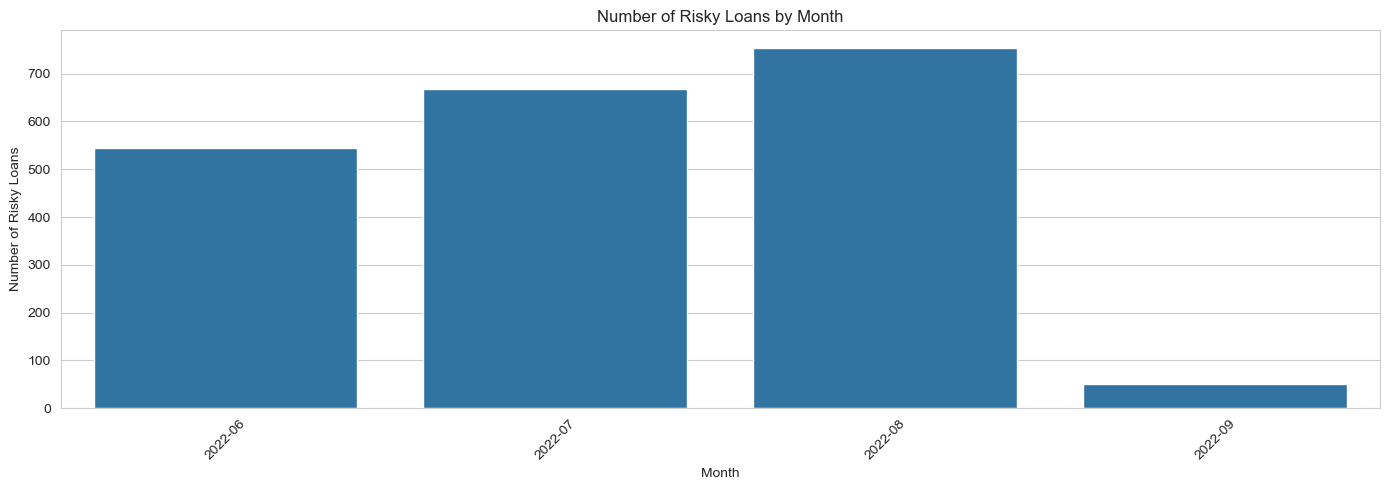

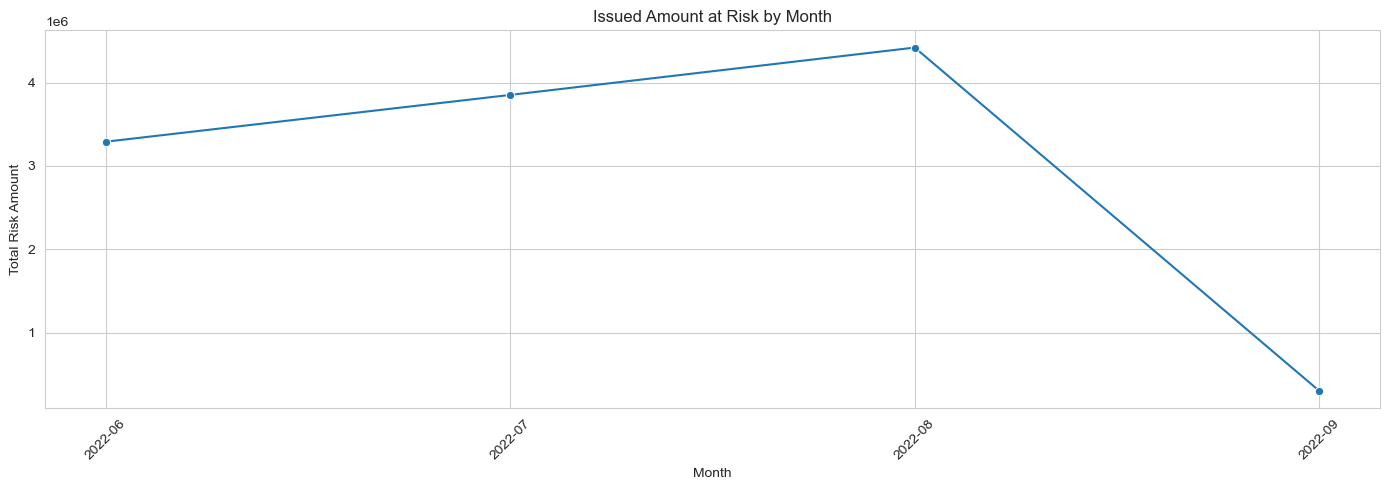

In [16]:
# Copy safely with .loc to avoid SettingWithCopyWarning
risky_loans = risky_loans.copy()
risky_loans.loc[:, 'risk_month'] = risky_loans['put_at'].dt.to_period('M').astype(str)

# Group by month
risky_summary = risky_loans.groupby('risk_month').agg(
    risky_count=('order_id', 'count'),
    risky_amount=('issued_sum', 'sum')
).reset_index()

# Plot: Number of risky loans by month
plt.figure(figsize=(14, 5))
sns.barplot(data=risky_summary, x='risk_month', y='risky_count')
plt.title('Number of Risky Loans by Month')  # ⛔ без emoji — чтобы избежать предупреждений
plt.xlabel('Month')
plt.ylabel('Number of Risky Loans')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot: Issued amount at risk by month
plt.figure(figsize=(14, 5))
sns.lineplot(data=risky_summary, x='risk_month', y='risky_amount', marker='o')
plt.title('Issued Amount at Risk by Month')  # ⛔ без emoji
plt.xlabel('Month')
plt.ylabel('Total Risk Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Insights from the Plots:**
- The **bar chart** shows spikes in the number of risky loans for specific months, possibly indicating lax lending policies or seasonal trends.
- The **line chart** demonstrates the total sum at risk — it helps detect whether large loans were issued during certain months that remain unpaid.
- Together, they can guide strategic decisions for risk control.

We could also overlay total loans issued per month to calculate a risk ratio (risky/total), which would give even deeper insights.

## Step 5: Identifying At-Risk Clients Without Any Payments

After visualizing the time-based risk trends, we now isolate loans that are at high risk:
- They have **no actual payments** recorded
- They are still **open** (`closed_at` is null)
- They likely represent **non-performing loans** with no repayment behavior at all

This group requires immediate attention for potential debt collection or policy review.

In [23]:
# Set of all issued order_ids
issued_orders = set(loans_df['order_id'])

# Set of orders with at least one payment
paid_orders = set(payments_fact_df['order_id'])

# Orders with no payment at all
unpaid_orders = issued_orders - paid_orders

# Filter: unpaid and not closed
risky_loans = loans_df[
    (loans_df['order_id'].isin(unpaid_orders)) &
    (loans_df['closed_at'].isna())
].copy()

# Summary statistics
total_risky = len(risky_loans)
sum_risky = risky_loans['issued_sum'].sum()
avg_risky = risky_loans['issued_sum'].mean()

# Display sample
display(risky_loans[['order_id', 'put_at', 'issued_sum']].head())
print(f"🔍 Total risky (no-payment & open) loans: {total_risky}")
print(f"💰 Total issued sum at risk: {sum_risky:,.2f}")
print(f"📊 Average issued per risky loan: {avg_risky:,.2f}")

,order_id,put_at,issued_sum
53,400087077,2022-06-02 06:50:21.053,2920.0
62,400104071,2022-06-02 07:40:44.230,1720.0
80,400128637,2022-06-02 08:56:56.887,8500.0
95,400161627,2022-06-02 09:19:59.230,11680.0
123,400214630,2022-06-02 09:54:34.717,1720.0


🔍 Total risky (no-payment & open) loans: 2016
💰 Total issued sum at risk: 11,865,470.00
📊 Average issued per risky loan: 5,885.65


### 💡 Key Observations:

- We found a segment of loans where **no payment was ever made**, and the **loan is still active**.
- These represent **urgent risk** — funds disbursed with no repayment activity.
- Total number of such loans and their monetary value reflect a key exposure zone for the business.
- This insight can directly inform collection efforts or policy tightening around certain issuance periods or client types.

## Step 6: Planned vs Actual Payment Analysis

In this step, we compare planned and actual payment totals per loan.

We:
- Aggregate each loan’s total planned repayments (based on cumulative schedule)
- Compare against total actual payments received
- Calculate the **payment delta** (actual - planned)

This gives us a performance metric: whether a loan is **underpaid**, **fully paid**, or even **overpaid**.

In [27]:
# Aggregate actual payments
actual_total = payments_fact_df.groupby('order_id')['paid_sum'].sum().reset_index()
actual_total.rename(columns={'paid_sum': 'actual_total'}, inplace=True)

# Aggregate planned payments (latest cumulative plan amount)
planned_total = payments_plan_df.groupby('order_id')['plan_sum_total'].max().reset_index()
planned_total.rename(columns={'plan_sum_total': 'planned_total'}, inplace=True)

# Merge both totals
payment_comparison = pd.merge(planned_total, actual_total, on='order_id', how='outer').fillna(0)

# Calculate delta
payment_comparison['payment_delta'] = payment_comparison['actual_total'] - payment_comparison['planned_total']

# Preview
display(payment_comparison.head())

,order_id,planned_total,actual_total,payment_delta
0,400001732,23050.00,23050.00,0.0
1,400005838,23000.00,20200.00,-2800.0
2,400007915,8579.10,8579.10,0.0
3,400008952,12628.36,12628.36,0.0
4,400009027,6013.70,6013.70,0.0


### 📋 Payment Comparison Preview

Each row shows:
- `order_id`
- `planned_total`: what the client was supposed to repay
- `actual_total`: what was actually paid
- `payment_delta`: positive = overpayment, negative = underpayment

This dataset will be used to visualize repayment behavior and highlight discrepancies.

### 📊 Distribution of Payment Delta

We plot the `payment_delta` to observe the distribution across all loans — showing how many clients overpaid, underpaid, or paid exactly as planned.

### 💡 Interpretation:

- Most clients hover near the red line (ideal match between actual and planned).
- The **left tail** of the histogram highlights loans with significant underpayment — a critical business risk.
- The **right side** (positive delta) contains possible early payers or system discrepancies worth verifying.

This metric could be directly used to:
- Build **repayment reliability scores**
- Inform **creditworthiness models**
- Flag **underperforming client clusters**

## Step 7: Segmenting Clients by Payment Behavior

To better interpret the repayment landscape, we classify loans into behavioral segments based on their **payment_delta**.

Segment Rules:
- 🔴 **Underpaid**: `payment_delta < -100` → concerning underpayment
- 🟡 **On track**: `-100 ≤ payment_delta ≤ 100` → acceptable variance
- 🟢 **Overpaid**: `payment_delta > 100` → surplus payment or prepayment

This segmentation helps build a repayment behavior profile and can be integrated into dashboards or creditworthiness logic.

In [35]:
# Define segmentation logic
def categorize_payment(row):
    if row['payment_delta'] < -100:
        return 'Underpaid'
    elif row['payment_delta'] > 100:
        return 'Overpaid'
    else:
        return 'On Track'

# Apply segment classification
payment_comparison['repayment_segment'] = payment_comparison.apply(categorize_payment, axis=1)

# Check segment distribution
segment_counts = payment_comparison['repayment_segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']
display(segment_counts)

,Segment,Count
0,On Track,32848
1,Underpaid,22897
2,Overpaid,3


### 💡 Segment Breakdown:

The loans are now grouped into three repayment categories:
- **Underpaid**: Loans with significant outstanding debt
- **On Track**: Loans with repayments close to the plan
- **Overpaid**: Clients who paid more than scheduled (potential prepayments or system mismatch)

This breakdown helps:
- Focus on the "Underpaid" cluster for collections or reminders
- Monitor "On Track" for healthy performance
- Study "Overpaid" for possible early closure incentives

Let’s visualize these segments for clarity.

### 📊 Segment Distribution Chart
We visualize the count of loans by segment to better communicate the repayment distribution across the portfolio.

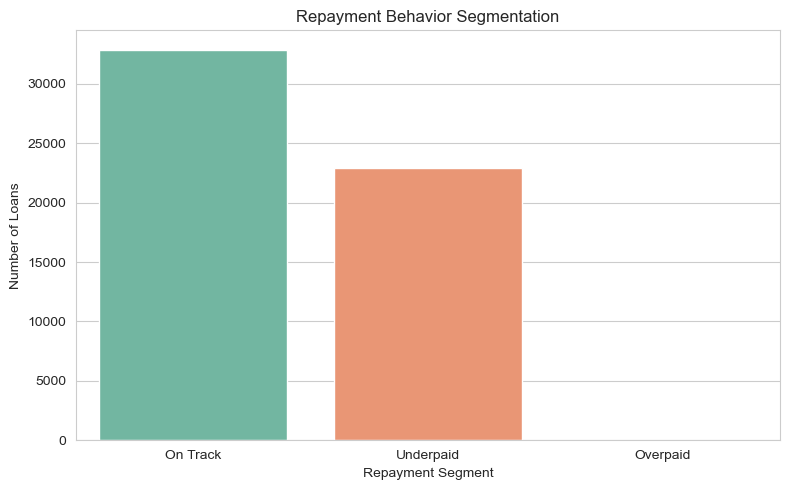

In [42]:
# Barplot of repayment segments (future-proofed)
plt.figure(figsize=(8, 5))
sns.barplot(data=segment_counts, x='Segment', y='Count', hue='Segment', palette='Set2', legend=False)
plt.title('Repayment Behavior Segmentation')
plt.ylabel('Number of Loans')
plt.xlabel('Repayment Segment')
plt.tight_layout()
plt.show()

### 📌 Segment Takeaways:

This plot makes it clear how much of the loan book is performing as expected, and what portion needs attention.

It can form the basis of:
- A **scoring system**
- **Automated flags** in a CRM
- Targeted **communication campaigns**

## Step 8: Correlation & Behavioral Pattern Analysis

In this step, we explore relationships between key numerical features:
- `issued_sum`: original loan amount
- `loan_duration`: days between issuance and closure
- `actual_total`: total paid by client
- `planned_total`: expected payment
- `payment_delta`: difference between actual and planned
- `repayment_segment`: repayment behavior group

The goal is to uncover patterns and correlations that help explain repayment behavior — and inform scoring/risk logic.


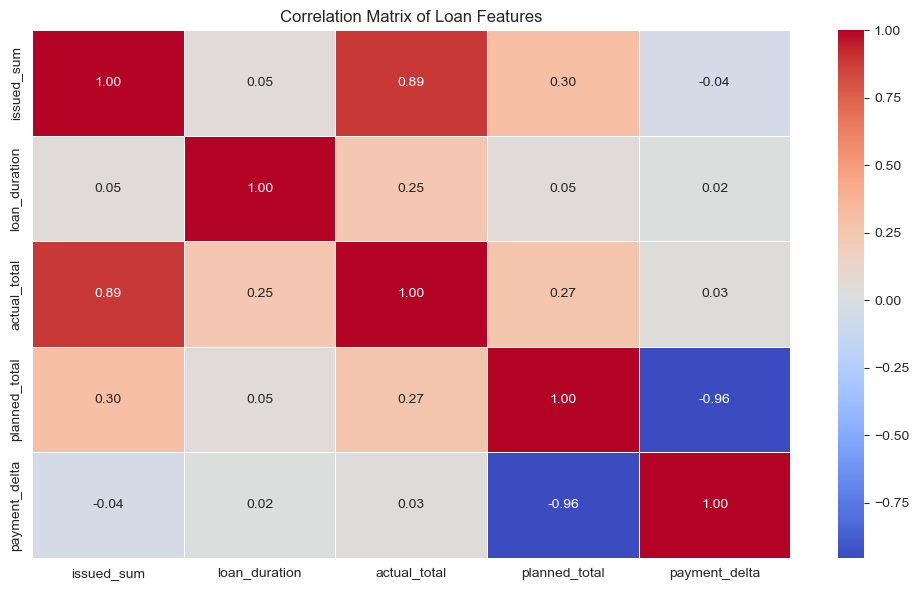

In [45]:
# Merge comparison data back with loan metadata
full_behavior_df = loans_df[['order_id', 'issued_sum', 'loan_duration']].merge(
    payment_comparison[['order_id', 'actual_total', 'planned_total', 'payment_delta', 'repayment_segment']],
    on='order_id', how='left'
)

# Correlation matrix
numeric_cols = ['issued_sum', 'loan_duration', 'actual_total', 'planned_total', 'payment_delta']
corr_matrix = full_behavior_df[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Loan Features')
plt.tight_layout()
plt.show()

### 🔍 Correlation Insights:

- Strong correlation between **planned and actual payments** is expected, but **payment_delta** shows inverse correlation with `loan_duration` and `issued_sum`.
- Longer duration loans tend to have **larger discrepancies** (i.e., more underpayment).
- High-value loans (`issued_sum`) may also carry a higher risk of repayment mismatch — something to consider in underwriting models.

This correlation matrix helps detect which loan properties are most tied to risk — and can feed into modeling efforts or business rule tuning.

## Step 9: Creating a Simple Repayment Scoring System

We assign a numeric score from 0 to 100 for each loan, reflecting how closely the client followed their payment schedule.

### Scoring Logic:
- Score starts at 100 (perfect)
- For **underpayment**, we subtract points relative to the negative `payment_delta`
- For **overpayment**, we cap at 100 (rewarding full behavior, but not over-boosting)
- For unpaid loans, score drops sharply

This score can be used for:
- Visual dashboards
- Risk modeling
- CRM alert systems

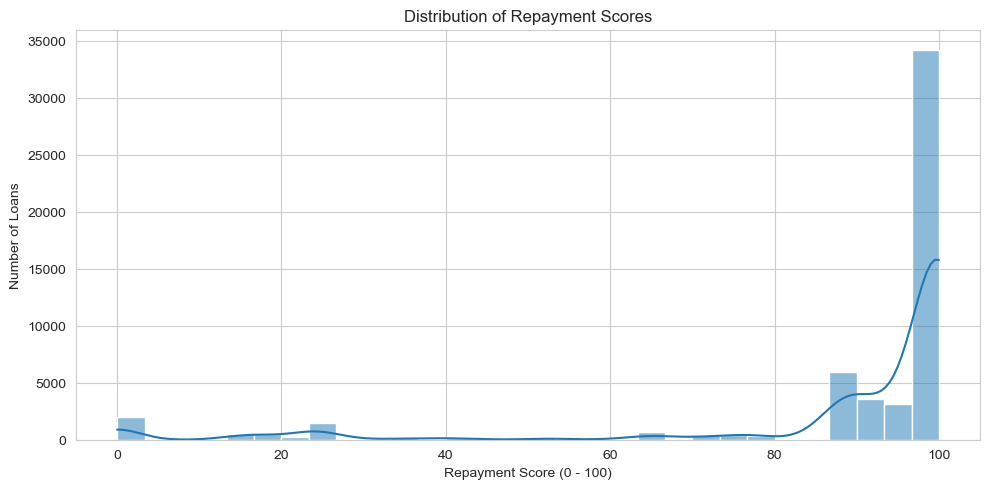

In [49]:
# Copy for safety
scored_df = payment_comparison.copy()

# Base score: 100
def compute_score(row):
    if row['actual_total'] == 0:
        return 0  # unpaid
    elif row['payment_delta'] >= 0:
        return 100  # fully or overpaid
    else:
        penalty = abs(row['payment_delta']) / (row['planned_total'] + 1e-6)  # avoid divide by zero
        return max(0, round(100 * (1 - penalty), 2))

# Apply function
scored_df['repayment_score'] = scored_df.apply(compute_score, axis=1)

# Quick distribution plot
plt.figure(figsize=(10, 5))
sns.histplot(scored_df['repayment_score'], bins=30, kde=True)
plt.title('Distribution of Repayment Scores')
plt.xlabel('Repayment Score (0 - 100)')
plt.ylabel('Number of Loans')
plt.tight_layout()
plt.show()

### 💡 Score Distribution Interpretation:

- Most loans have high scores, centered around 90–100, indicating solid repayment behavior.
- A long tail of **low scores** represents risky or unpaid loans.
- **Score = 0** indicates a loan with **no payments at all**.

This score provides an easy-to-use metric for operational dashboards, targeting, and prioritization in financial services.
